In [165]:
from keras.preprocessing import sequence
from keras.models import Sequential, Model, load_model
from keras.layers import GRU, Dense, Dropout, Input, concatenate
from keras.utils import np_utils
from keras.optimizers import Adam
from copy import deepcopy
import json
import pandas as pd
import pickle
import math
import datetime
import tensorflow as tf

## Check GPU on keras and tensorflow-gpu

In [2]:
import tensorflow as tf
hello=tf.constant('Hello,TensorFlow!')

sess=tf.Session(config=tf.ConfigProto(log_device_placement=True))

print(sess.run(hello))

b'Hello,TensorFlow!'


In [103]:
from tensorflow.python.client import device_lib
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())
print(device_lib.list_local_devices())

[]
[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4195439473557275804
]


# Preparing data

In [179]:
# variable
words = [
    'come quickly', 'emergency', 'father', 'fever', 'good luck',
    'headache', 'hello', 'help', 'hi', 'hungry',
    'like', 'mother', 'mother_father', 'mother_mother', 'not ok',
    'quickly', 'sorry', 'tomorrow', 'yogurt'
]
data_per_word = 27
# data_length = data_per_word * len(words)
speedup_max = 1.15
timesteps = 50
augment_timesteps = math.ceil(timesteps * speedup_max) # add speedup
dimensions = 22

In [180]:
def get_feature(frame):
    finger_name = ['thumb', 'index', 'middle', 'ring', 'pinky']
    hand_name = ['left', 'right']
    
    fingertip_pos = np.zeros([2, 5, 3])
    
    hand_palm_pos = np.zeros([2, 3])
    hand_palm_rpy = np.zeros([2, 3])
    hand_palm_unit_vector = np.zeros([2, 3])
    arm_direction = np.zeros([2, 3])
    
    feature = np.zeros([22])
    
    for hand_idx, hand in enumerate(hand_name):
        if not hand in frame['hands']:
            continue
        hand_palm_pos[hand_idx] = np.array(frame['hands'][hand]['hand_palm_position'])
        hand_palm_rpy[hand_idx] = np.array([ frame['hands'][hand]['roll'],
                                                    frame['hands'][hand]['pitch'],
                                                    frame['hands'][hand]['yaw']])
        hand_palm_unit_vector[hand_idx] = np.cross(
            frame['hands'][hand]['fingers']['index']['bones']['proximal']['direction'],
            frame['hands'][hand]['fingers']['middle']['bones']['proximal']['direction']
        )
        arm_direction[hand_idx] = np.array(frame['hands'][hand]['arm']['direction'])
        for finger_idx, finger in enumerate(finger_name):
            fingertip_pos[hand_idx, finger_idx] = (
                np.array(frame['hands'][hand]['fingers'][finger]['bones']['distal']['next_joint'])
            )
            
    fingertip_pos_shift = np.roll(fingertip_pos, 1, axis=1)
    dist_btw_fingertip = np.linalg.norm(fingertip_pos - fingertip_pos_shift, axis=2)
        
    feature[0:6] = hand_palm_pos.reshape(6)
    feature[6:12] = hand_palm_rpy.reshape(6)
    feature[12:22] = dist_btw_fingertip.reshape(10)
#     feature[22:28] = hand_palm_unit_vector.reshape(6)
#     feature[28:34] = arm_direction.reshape(6)
    
    return feature
    

In [84]:
def get_timesteps(json_data, pick_frame_every_no): 
    timesteps = np.zeros([0, dimensions])
    for frame_no, frame in enumerate(json_data):
        if frame_no % pick_frame_every_no != 0 or not frame['hands']:
            continue
        feature = get_feature(frame)
        timesteps = np.vstack((timesteps, feature))
    return timesteps

In [ ]:
def get_fake_speedup_timesteps_2(percent, old_timesteps, old_pick_frame_every_no):
    timesteps = np.zeros([0, dimensions])
    pick_frame_every_no = old_pick_frame_every_no*(100+percent)//100
    timesteps_length = (old_timesteps.shape[0] * old_pick_frame_every_no) // pick_frame_every_no
    
    for new_index in range(1, timesteps_length):
        start_old_index = (new_index * pick_frame_every_no) // old_pick_frame_every_no
        x1 = old_pick_frame_every_no*start_old_index
        x2 = old_pick_frame_every_no*(start_old_index + 1)
        h1, h2 = old_timesteps[start_old_index : start_old_index + 2]
        _x = (new_index * pick_frame_every_no)
        
        feature = ((_x-x1)/(x2-x1))*(h2-h1) + h1
        
        timesteps = np.vstack((timesteps, feature))
        
    return timesteps

In [85]:
def get_augmentation(percent, old_timesteps, old_pick_frame_every_no):
    # percent positive means shrink
    timesteps = np.zeros([0, dimensions])
    pick_frame_every_no = round(old_pick_frame_every_no*(100+percent)/100)
    timesteps_length = (old_timesteps.shape[0] * old_pick_frame_every_no) // pick_frame_every_no
    
    for new_index in range(1, timesteps_length):
        start_old_index = (new_index * pick_frame_every_no) // old_pick_frame_every_no
        if (start_old_index + 2 > len(old_timesteps)) : break
        x1 = old_pick_frame_every_no*start_old_index
        x2 = old_pick_frame_every_no*(start_old_index + 1)
        h1, h2 = old_timesteps[start_old_index : start_old_index + 2]
        
        _x = (new_index * pick_frame_every_no)
        
        feature = ((_x-x1)/(x2-x1))*(h2-h1) + h1
        
        timesteps = np.vstack((timesteps, feature))
        
    return timesteps

# Dataset and Data augmentation

In [88]:
max_frame = 0
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        if max_frame < len(json_data):
            max_frame = len(json_data)

In [89]:
pick_frame_every_no = max_frame // 50 + 1
# pick_frame_every_no = int((max_frame * (speedup < 0 and (100-speedup)/100 or 1)) // 50 + 1)
print(pick_frame_every_no)

12


In [90]:
x_original = np.zeros([0, timesteps, dimensions])
y_original = np.zeros([0])
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        _timesteps = get_timesteps(json_data, pick_frame_every_no)
        _timesteps = np.vstack((_timesteps, np.zeros([timesteps - _timesteps.shape[0], dimensions])))
        x_original = np.vstack((x_original, [_timesteps]))
        y_original = np.append(y_original, word_no)

In [91]:
x_augment = {}
augment_levels = [0.85, 0.90, 1.00, 1.10, 1.15]

for level in augment_levels:
    temp_augment = np.zeros([0, augment_timesteps, dimensions])
    for i in range(x_original.shape[0]):
        old_timesteps = x_original[i]
        if (level != 1.00) :
            _timesteps = get_augmentation(int(100 - level*100), old_timesteps, pick_frame_every_no)
        else:
            _timesteps = old_timesteps
        _timesteps = np.vstack((_timesteps, np.zeros([augment_timesteps - _timesteps.shape[0], dimensions])))
        
        temp_augment = np.vstack((temp_augment, [_timesteps]))
    x_augment[level] = temp_augment

In [157]:
with open('./extracted_feature/original_100418GridSearch.pkl', 'wb') as file_pi:
    pickle.dump([x_original, y_original, x_augment], file_pi)

### ** Important Load data here:

In [45]:
with open('./extracted_feature/original_080418GridSearch.pkl', 'rb') as handle:
    [x_original, y_original, x_augment] = pickle.load(handle)

# Normalize data

In [162]:
def get_x_norm(x):
    x_std = x.std(axis=(0,1), keepdims=True)
    x_mean = x.mean(axis=(0,1), keepdims=True)
    x_norm = (x-x_mean)/x_std
    return x_norm

In [195]:
def get_train_and_test(x, y):
    x_norm = get_x_norm(x)
    data_length = x_norm.shape[0]
    x_train = np.zeros([data_length * 2 // 3, augment_timesteps, dimensions])
    y_train = np.zeros([data_length * 2 // 3])
    x_test = np.zeros([data_length // 3, augment_timesteps, dimensions])
    y_test = np.zeros([data_length // 3])
    for idx in range(data_length):
        if idx % 3 == 2:
            x_test[idx // 3] = x_norm[idx]
            y_test[idx // 3] = y[idx]
        else:
            x_train[idx - idx // 3] = x_norm[idx]
            y_train[idx - idx // 3] = y[idx]
    
    # shuffle training set
    shuffle_train = np.arange(len(x_train))
    np.random.seed(0)
    np.random.shuffle(shuffle_train)
    x_train_shuffle = np.zeros([data_length * 2 // 3, augment_timesteps, dimensions])
    y_train_shuffle = np.zeros([data_length * 2 // 3])
    for idx, item in enumerate(shuffle_train):
        x_train_shuffle[idx] = x_train[item]
        y_train_shuffle[idx] = y_train[item]
        
    # encoding label
    Y_train_shuffle = np_utils.to_categorical(y_train_shuffle, len(words))
    Y_test = np_utils.to_categorical(y_test, len(words))
        
    return [[x_train_shuffle, Y_train_shuffle], [x_test, Y_test]]

In [76]:
augmentation = [0.9, 1.0, 1.1]
x = np.vstack(([x_augment[n] for n in augmentation]))
y = []
for i in augmentation:
    y = np.append(y, y_original)
    

[[x_train_shuffle, Y_train_shuffle], [x_test, Y_test]] = get_train_and_test(x, y)

# Modeling Method

In [194]:
def get_model(GRU_size, dense_layer):
    fingers = Input(shape=(augment_timesteps, dimensions), name='fingers')
    fingers_layers = GRU(GRU_size, activation='tanh', recurrent_activation='hard_sigmoid', dropout=0.2, recurrent_dropout=0.2)(fingers)
    for i in range(dense_layer):
        fingers_layers = Dense(GRU_size, activation='relu')(fingers_layers)
        fingers_layers = Dropout(0.2)(fingers_layers)
    output_layer = Dense(len(words), activation='softmax')(fingers_layers)
    model = Model(inputs=fingers, outputs=output_layer)
    adam = Adam(lr=0.01, decay=0.0005)
    model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [349]:
def grid_search(grid_search_layer, x_augment, y_original, epochs = 1000, note = '', verbose = 1):
    model_and_history = {}
    file_name = './history/model_and_history_'+ str(datetime.datetime.now().strftime("%A, %d. %B %Y %I_%M%p")+ str(note)) +'.pkl'

    for augmentation in grid_search_layer['augmentation']:
        model_and_history[str(augmentation)] = {}
        x = np.vstack(([x_augment[n] for n in augmentation]))
        y = []
        for i in augmentation:
            y = np.append(y, y_original)
        
        for GRU in grid_search_layer['GRU']:
            model_and_history[str(augmentation)][GRU] = {}
            
            for dense_layer in grid_search_layer['dense_layer']:
                print(augmentation, 'GRU:', GRU, ', dense_layer:',dense_layer)
                model = get_model(GRU, dense_layer)
                [[x_train_shuffle, Y_train_shuffle], [x_test, Y_test]] = get_train_and_test(x, y)
                
                np.random.seed(0)
                tf.set_random_seed(0)
                
                history = model.fit(x_train_shuffle, Y_train_shuffle, validation_data=(x_test, Y_test), epochs=epochs, batch_size=8, shuffle=True, verbose=verbose)
                
                score, acc = model.evaluate(x_test, Y_test)
                print('Test score & accuracy:', score, acc)
                
                model_and_history[str(augmentation)][GRU][dense_layer] = {
#                     'model': model,
#                     'history': history,
                    'score': score,
                    'acc': acc
                }
                
                txt = '{}_{}_{}_Note_{}'.format(augmentation, GRU, dense_layer, str(note))
                print(txt)
                model.save("./history/model_grid_search_"+ txt +".h5")
                with open('./history/history_'+ txt +'.pkl', 'wb') as file_pi:
                    pickle.dump(history.history, file_pi)
                    
                with open(file_name, 'wb') as file_pi:
                    pickle.dump(model_and_history, file_pi)
    
    return model_and_history, file_name

# Start grid searching >////<

In [293]:
def get_x_augment_custom():
    x_augment_custom = {}
    dimensions = 22
    for key, pack in x_augment.items():
        x_augment_custom[key] = pack[:,:,0:22]
    return x_augment_custom

In [346]:
# grid_search_layer = {
#     'GRU': [16, 32, 64, 128],
#     'dense_layer': [1,2,3],
#     'augmentation': [[0.90, 1.00, 1.10], [0.85, 0.90, 1.00, 1.10, 1.15]],
# }
grid_search_layer = {
    'GRU': [64],
    'dense_layer': [3],
    'augmentation': [[0.90, 1.00, 1.10]],
}

x_augment_custom = get_x_augment_custom()

model_and_history = {}
for i in range(4):
    note = '_test_' + str(i)
    model_and_history[i], model_and_history[str(i) + '_file_name'] = grid_search(grid_search_layer, x_augment_custom, y_original, 1, verbose=0, note = note)
    
# for i in grid_search_layer['dense_layer']:
#     temp = deepcopy(grid_search_layer)
#     temp['dense_layer'] = [i]
#     print(temp)
#     model_and_history[i], model_and_history[str(i) + '_file_name'] = grid_search(temp, x_augment, y_original, 10,'dense_layer=' + i)

[0.9, 1.0, 1.1] GRU: 64 , dense_layer: 3
513/513 [==============================] - 0s 338us/step
Test score & accuracy: 2.94496541739 0.0526315789474
[0.9, 1.0, 1.1]_64_3_Note__test_0
[0.9, 1.0, 1.1] GRU: 64 , dense_layer: 3
513/513 [==============================] - 0s 347us/step
Test score & accuracy: 2.94496541739 0.0526315789474
[0.9, 1.0, 1.1]_64_3_Note__test_1
[0.9, 1.0, 1.1] GRU: 64 , dense_layer: 3
513/513 [==============================] - 0s 339us/step
Test score & accuracy: 2.94496541739 0.0526315789474
[0.9, 1.0, 1.1]_64_3_Note__test_2
[0.9, 1.0, 1.1] GRU: 64 , dense_layer: 3
513/513 [==============================] - 0s 363us/step
Test score & accuracy: 2.94496541739 0.0526315789474
[0.9, 1.0, 1.1]_64_3_Note__test_3


In [153]:
from pydash import merge
from os import listdir
from os.path import isfile, join

mypath = './history'
history_and_model_files = [ './history/' + f for f in listdir(mypath) if isfile(join(mypath, f)) and f.find('model_and_history') > -1]

model_and_history = {}
file_list = history_and_model_files + [
    './history_spec/model_and_history_Tuesday, 10. April 2018 03_33AM64.pkl',
    './history_spec/model_and_history_Tuesday, 10. April 2018 03_56AM.pkl',
    './history_spec/model_and_history_Tuesday, 10. April 2018 05_04AM64_old_feature.pkl',
    './history_spec/model_and_history_Tuesday, 10. April 2018 05_25AM.pkl'
]

for file_name in file_list:
    with open(file_name, 'rb') as handle:
        model_and_history = merge(model_and_history, pickle.load(handle))
        
# print(model_and_history)

In [154]:
best_acc_idx = {
    'augmentation': None,
    'GRU': None,
    'dense_layer': None
}

best_acc = 0
for augmentation, pack1 in model_and_history.items():
    for GRU, pack2 in pack1.items():
        for dense_layer, pack3 in pack2.items():
            print(pack3['acc'], augmentation, GRU, dense_layer)
            if pack3['acc'] > best_acc:
                best_acc = pack3['acc']
                best_acc_idx['augmentation'] = augmentation
                best_acc_idx['GRU'] = GRU
                best_acc_idx['dense_layer'] = dense_layer
                
print('best acc:',best_acc, ', at:', best_acc_idx)

0.74269005848 [0.9, 1.0, 1.1] 128 1
0.424951267057 [0.9, 1.0, 1.1] 128 2
0.573099415205 [0.9, 1.0, 1.1] 128 3
0.797270955166 [0.9, 1.0, 1.1] 32 1
0.748538011696 [0.9, 1.0, 1.1] 32 2
0.732943469786 [0.9, 1.0, 1.1] 32 3
0.612085769981 [0.9, 1.0, 1.1] 16 1
0.635477582846 [0.9, 1.0, 1.1] 16 2
0.387914230019 [0.9, 1.0, 1.1] 16 3
0.808966861598 [0.9, 1.0, 1.1] 64 1
0.820662768031 [0.9, 1.0, 1.1] 64 2
0.805068226121 [0.9, 1.0, 1.1] 64 3
0.831578947647 [0.85, 0.9, 1.0, 1.1, 1.15] 128 1
0.59064327447 [0.85, 0.9, 1.0, 1.1, 1.15] 128 2
0.690058478835 [0.85, 0.9, 1.0, 1.1, 1.15] 128 3
0.771929824073 [0.85, 0.9, 1.0, 1.1, 1.15] 64 1
0.781286548941 [0.85, 0.9, 1.0, 1.1, 1.15] 64 2
0.818713449526 [0.85, 0.9, 1.0, 1.1, 1.15] 64 3
0.794152046296 [0.85, 0.9, 1.0, 1.1, 1.15] 32 1
0.743859648914 [0.85, 0.9, 1.0, 1.1, 1.15] 32 2
0.712280700988 [0.85, 0.9, 1.0, 1.1, 1.15] 32 3
0.686549707393 [0.85, 0.9, 1.0, 1.1, 1.15] 16 1
0.631578947717 [0.85, 0.9, 1.0, 1.1, 1.15] 16 2
0.438596491402 [0.85, 0.9, 1.0, 1.1,

In [323]:
interested_model = model_and_history[2]['[0.90, 1.00, 1.10]'][64][3]['model']

In [324]:
interested_model

# Continue train model

In [305]:
def continue_train_model(model, x_augment, y_original, augmentation, epochs = 1000, verbose = 1):
    x = np.vstack(([x_augment[n] for n in augmentation]))
    y = []
    for i in augmentation:
        y = np.append(y, y_original)
        
    [[x_train_shuffle, Y_train_shuffle], [x_test, Y_test]] = get_train_and_test(x, y)

    np.random.seed(0)
    tf.set_random_seed(0)

    history = model.fit(x_train_shuffle, Y_train_shuffle, validation_data=(x_test, Y_test), epochs=epochs, batch_size=8, shuffle=True, verbose=verbose)
    
    return model, history

In [350]:
interested_model = load_model("./history/model_grid_search_[0.9, 1.0, 1.1]_64_3_Note__test_3.h5")

x_augment_custom = get_x_augment_custom()

model, history = continue_train_model(interested_model, x_augment_custom, y_original, [0.90, 1.00, 1.10], 1)

txt = str(datetime.datetime.now().strftime("%A, %d. %B %Y %I_%M%p")) + '_' + 'test'
model.save("./interested_model/model_"+ txt +".h5")
with open('./interested_model/history_'+ txt +'.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Train on 1026 samples, validate on 513 samples
Epoch 1/1
1026/1026 [==============================] - 8s 8ms/step - loss: 2.9716 - acc: 0.0429 - val_loss: 2.9688 - val_acc: 0.0507


## Editing old stuffs

In [125]:
file_name = '[0.9, 1.0, 1.1]_64_3_Note_64_08042018'

try:
    f = h5py.File('./history/model_grid_search_'+ file_name +'.h5', 'r+')
    del f['optimizer_weights']
    f.close()
except:
    None

model = load_model("./history/model_grid_search_"+ file_name +".h5")
with open('./history/history'+ file_name +'.pkl', 'rb') as handle:
    history = pickle.load(handle)

In [115]:
score, acc = model.evaluate(x_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

513/513 [==============================] - 2s 3ms/step
Test score: 1.11924052857
Test accuracy: 0.805068226121


dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])


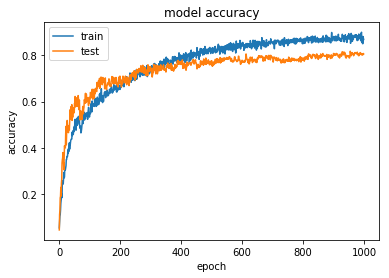

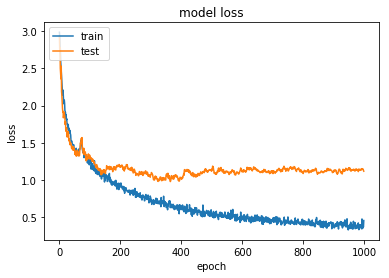

In [291]:
import matplotlib.pyplot as plt
history_talbe = 'history' in history and history.history or history
# list all data in history
print(history.keys())
# summarize history for accuracy
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediction section

In [109]:
def generate_confusion_matrix(prediction, y_actual, words):
    confusion_matrix = np.zeros([len(words), len(words)])
    prediction_word_index = np.argmax(prediction, axis = 1)

    for idx in range(len(prediction_word_index)):
        actual = y_actual[idx]
        result = prediction_word_index[idx]
        confusion_matrix[int(actual)][result] += 1
        
    return confusion_matrix

In [119]:
def cal_acc(confusion_matrix, words, test_data_per_word):
    test_acc = 0

    for idx in range(len(words)):
        test_acc += confusion_matrix[idx][idx]
    test_acc /= (test_data_per_word * len(words))

    return test_acc


In [112]:
def cal_acc(confusion_matrix, words, test_data_per_word):
    test_acc = 0

    for idx in range(len(words)):
        test_acc += confusion_matrix[idx][idx]
    test_acc /= (test_data_per_word * len(words))

    return test_acc


In [104]:
def plot_confusion_matrix(confusion_matrix, label_x, label_y):
    import seaborn as sn
    import pandas as pd
    import matplotlib.pyplot as plt
    %matplotlib inline

    df_cm = pd.DataFrame(confusion_matrix, label_x, label_y)
    plt.figure(figsize = (15,12))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})# font size

In [105]:
def predict_and_plot(x_test, y_test, words, test_data_per_word):
    prediction = model.predict(x_test, verbose = 1)
    confusion_matrix = generate_confusion_matrix(prediction, y_test, words)
    print('acc: ', cal_acc(confusion_matrix, words, test_data_per_word))
    plot_confusion_matrix(confusion_matrix, words, words)

### Predict Test dataset and plot

In [106]:
predict_and_plot(x_test, y_test, words, test_data_per_word = 18)

NameError: name 'y_test' is not defined

### Predict new test set from ./record_test

190/190 [==============================] - 0s 216us/step
acc:  0.736842105263


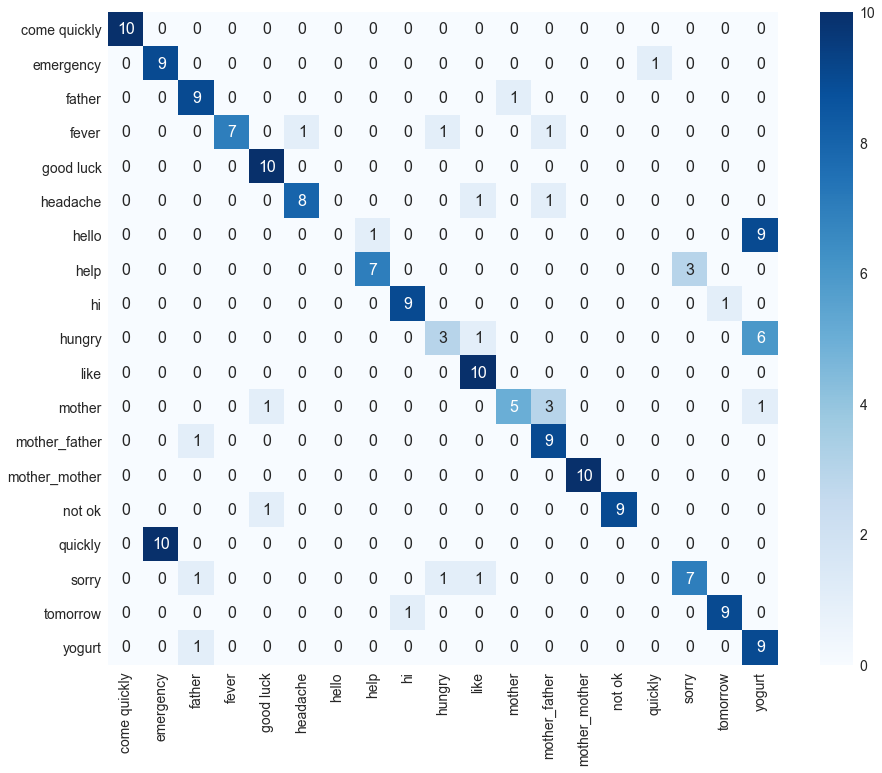

In [126]:
x_predict = np.zeros([0, timesteps, dimensions])
y_actual = np.zeros([0])

test_data_per_word = 10

for word_no, word in enumerate(words):
    for data_no in range(test_data_per_word):
        try:
            with open("./record_test/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)

        _timesteps = get_timesteps(json_data, pick_frame_every_no)
        _timesteps = np.vstack((_timesteps, np.zeros([timesteps - _timesteps.shape[0], dimensions])))
        x_predict = np.vstack((x_predict, [_timesteps]))
        y_actual = np.append(y_actual, word_no)
        
x_predict_norm = (x_predict-x_mean)/x_std
    
predict_and_plot(x_test = x_predict_norm, y_test = y_actual, words = words, test_data_per_word = 10)